# Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils

# Download data

Download data used to train classifiers.

### Read training file

In [2]:
data = pandas.read_csv('training.csv.gz')

In [3]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,...,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,...,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,...,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,...,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,...,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


### Looking at the labels

The training data contains six classes. Each class corresponds to a particle type. The goal is to predict type of a particle.

In [4]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Converting the particle types into class numbers.

In [5]:
data['Class'] = utils.get_class_ids(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Defining training features

The following set of features describe particle responses in the detector systems:

![features](pic/features.jpeg)

Also there are several combined features. The full list is following.

In [6]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['RICH_DLLbeBCK',
 'TrackNDoFSubdetector1',
 'FlagHcal',
 'EcalE',
 'RICH_DLLbeKaon',
 'RICH_DLLbeProton',
 'GhostProbability',
 'MuonLLbeBCK',
 'FlagRICH1',
 'DLLproton',
 'TrackP',
 'EcalDLLbeMuon',
 'FlagRICH2',
 'FlagSpd',
 'SpdE',
 'FlagMuon',
 'MuonLLbeMuon',
 'RICHpFlagProton',
 'RICHpFlagElectron',
 'HcalDLLbeMuon',
 'RICH_DLLbeMuon',
 'EcalDLLbeElectron',
 'TrackNDoFSubdetector2',
 'RICH_DLLbeElectron',
 'EcalShowerLongitudinalParameter',
 'MuonLooseFlag',
 'RICHpFlagMuon',
 'TrackQualityPerNDoF',
 'Calo3dFitQuality',
 'Calo2dFitQuality',
 'TrackNDoF',
 'DLLkaon',
 'FlagPrs',
 'TrackQualitySubdetector2',
 'HcalE',
 'BremDLLbeElectron',
 'HcalDLLbeElectron',
 'FlagEcal',
 'PrsDLLbeElectron',
 'FlagBrem',
 'DLLelectron',
 'RICHpFlagKaon',
 'TrackQualitySubdetector1',
 'DLLmuon',
 'RICHpFlagPion',
 'MuonFlag',
 'PrsE',
 'TrackDistanceToZ',
 'TrackPt']

### Dividing training data into 2 parts

In [7]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.10)

In [8]:
len(training_data), len(validation_data)

(120000, 1080000)

# Sklearn classifier

Training **Sklearn** classifier to provide lower **log loss** value.
And also tuning the classifier parameters to achieve the lowest **log loss** value on the validation sample.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.3, random_state=13,
                                min_samples_leaf=100, max_depth=3)
gb.fit(training_data[features].values, training_data.Class.values)

CPU times: user 1min 22s, sys: 32 ms, total: 1min 22s
Wall time: 1min 22s


### Log loss on the cross validation sample

In [11]:
# predict each track
proba_gb = gb.predict_proba(validation_data[features].values)

In [12]:
log_loss(validation_data.Class.values, proba_gb)

0.66903316252217382

# Keras neural network

Training **Keras** NN classifier to provide lower **log loss** value.
And also tuning the classifier parameters to achieve the lowest **log loss** value on the validation sample.

In [13]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.


In [14]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [15]:
nn = nn_model(len(features))
nn.fit(training_data[features].values, np_utils.to_categorical(training_data.Class.values), verbose=1, nb_epoch=5, batch_size=256)

/opt/conda/anaconda3/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
120000/120000 [==============================] - 1s - loss: 1.5298     
Epoch 2/5
120000/120000 [==============================] - 1s - loss: 1.3839     
Epoch 3/5
120000/120000 [==============================] - 1s - loss: 1.3583     
Epoch 4/5
120000/120000 [==============================] - 1s - loss: 1.3288     
Epoch 5/5
120000/120000 [==============================] - 1s - loss: 1.3102     


### Log loss on the cross validation sample

In [16]:
# predict each track
proba_nn = nn.predict_proba(validation_data[features].values)

1078304/1080000 [============================>.] - ETA: 0s

In [17]:
log_loss(validation_data.Class.values, proba_nn)

1.3022857417667681

# Quality metrics

Ploting ROC curves and signal efficiency dependence from particle mometum and transverse momentum values.

In [18]:
proba = proba_gb

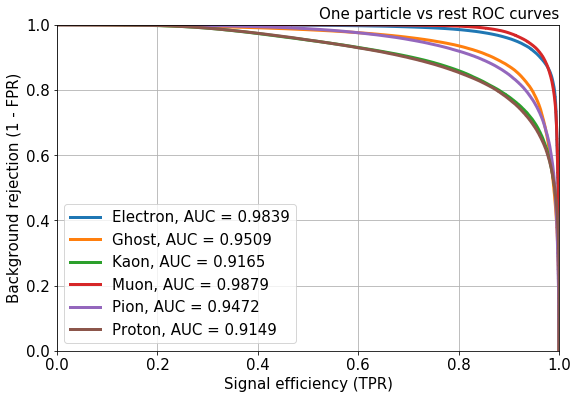

In [19]:
utils.plot_roc_curves(proba, validation_data.Class.values)

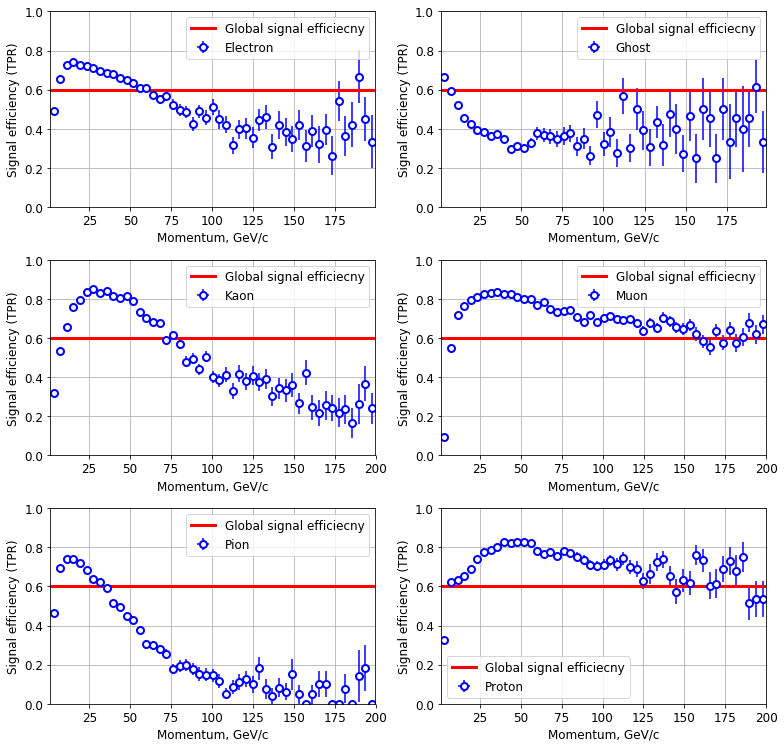

In [20]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

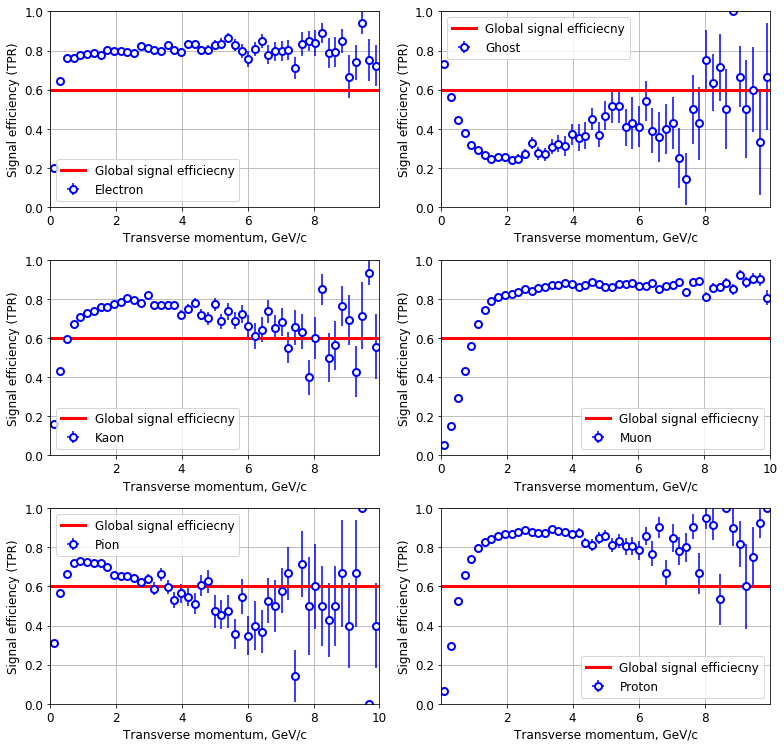

In [21]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

# Preparing submission

Selecting the best classifier and preparing the submission file.

In [22]:
test = pandas.read_csv('test.csv.gz')

In [23]:
best_model = gb

In [24]:
# predict test sample
submit_proba = best_model.predict_proba(test[features])
submit_ids = test.ID

In [25]:
from IPython.display import FileLink
utils.create_solution(submit_ids, submit_proba, filename='submission_file.csv.gz')

/mnt/mikhail91/coursera_programming_assignmens/week_2/task/submission_file.csv.gz